Classification of radio signals into pulsars or non-pulsar using K-nearest neighbors

INTRODUCTION:

A pulsar is a highly magnetized rotating neutron star that emits beams of electromagnetic radiation out of its magnetic poles.

Since pulsars rotate rapidly, the emission of a pulsar forms a pattern that repeats periodically. This emission pattern varies slightly with each rotation and is unique for a pulsar. Therefore, the signal from a pulsar is averaged over many rotations giving us the fold/integrated profile of a pulsar. Since the Integrated pulse profile is unique to a pulsar it is also called a pulsar’s fingerprint(Lyon, 2016).

In practice, most signals are due to radio frequency interference (RFI) and noise. Without additional information, all “candidate” signals collected by a radio telescope could be classified as pulsars. To help differentiate pulsars and non-pulsar signals, we also use the DM-SNR (Dispersion Measure vs Signal to Noise Ratio) curve for the signal(Eatough et al., 2020).
Our question is: Given a new candidate signal, can we classify it as a pulsar or non-pulsar?

We use the HTRU2 data set available at the UCL machine learning repository. In this dataset, we use characteristics such as mean, standard deviation, excess kurtosis, and skewness for both the integrated profile and DM-SNR curve of a signal. For each candidate signal, there is a class label which classifies the detection as either a pulsar(1) or non-pulsar(0); a human annotator has classified the signals.




In [1]:
#we install the themis library to use step_upsample and upsample our data 
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)
library(repr)
library(tidymodels) #for KNN classification
library(themis)
library(GGally)
library(ggplot2)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Column names are:
# M_IP -> Mean of the Integrated Profile
# SD_IP -> Standard deviation of the Integrated Profile
# EK_IP -> Excess kurtosis of the Integrated Profile
# SK_IP -> Skewness of the Integrated Profile
# M_DM_SNR -> Mean of the DM-SNR curve
# SD_DM_SNR -> Standard deviation of the DM-SNR curve
# EK_DM_SNR -> Excess kurtosis of the DM-SNR curve
# SK_DM_SNR -> Skewness of the DM-SNR curve
# CLASS -> Label for an observation pulsar(1) and non-pulsar(0)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "pulsar_data.zip")
unzip("pulsar_data.zip")
pulsar <- read_csv("HTRU_2.csv", 
                   col_names = c("M_IP","SD_IP","EK_IP","SK_IP","M_DM_SNR","SD_DM_SNR","EK_DM_SNR","SK_DM_SNR","CLASS")) |>
                mutate(CLASS = as_factor(CLASS))
pulsar
# CLASS variable is converted from double to factor type with two levels
# The data is tidy

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): M_IP, SD_IP, EK_IP, SK_IP, M_DM_SNR, SD_DM_SNR, EK_DM_SNR, SK_DM_SN...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


In [4]:
# Mean value for each variable for each class
# Number of observations in each class
pulsar_summarize <- pulsar|>
            group_by(CLASS)|>
            summarize(count = n(),
                      across(M_IP:SK_DM_SNR, mean))
pulsar_summarize

CLASS,count,M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,16259,116.56273,47.33974,0.2104401,0.380844,8.863258,23.28798,8.862674,113.62034
1,1639,56.69061,38.71060,3.1306554,15.553576,49.825995,56.46896,2.757069,17.93173


This data set contains 16259 observations for non-pulsars and 1639 observations for pulsars. This illustrates that most of the radio signals are non-pulsar making pulsars hard to find.

In [5]:
# NA values in each column
pulsar_na <- pulsar|>
             map_dfr( ~ sum(is.na(.)))
pulsar_na

M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0


We can see that there are no NA values in this data set.

The large number of non-pulsar observations makes it difficult to observe trends for pulsars on the same plot, so we split the data into pulsar and non-pulsar sets. For a given characteristic, we plot the graphs for pulsars and non-pulsars separately and then use the plot_grid function from the cowplot package to plot both graphs together.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



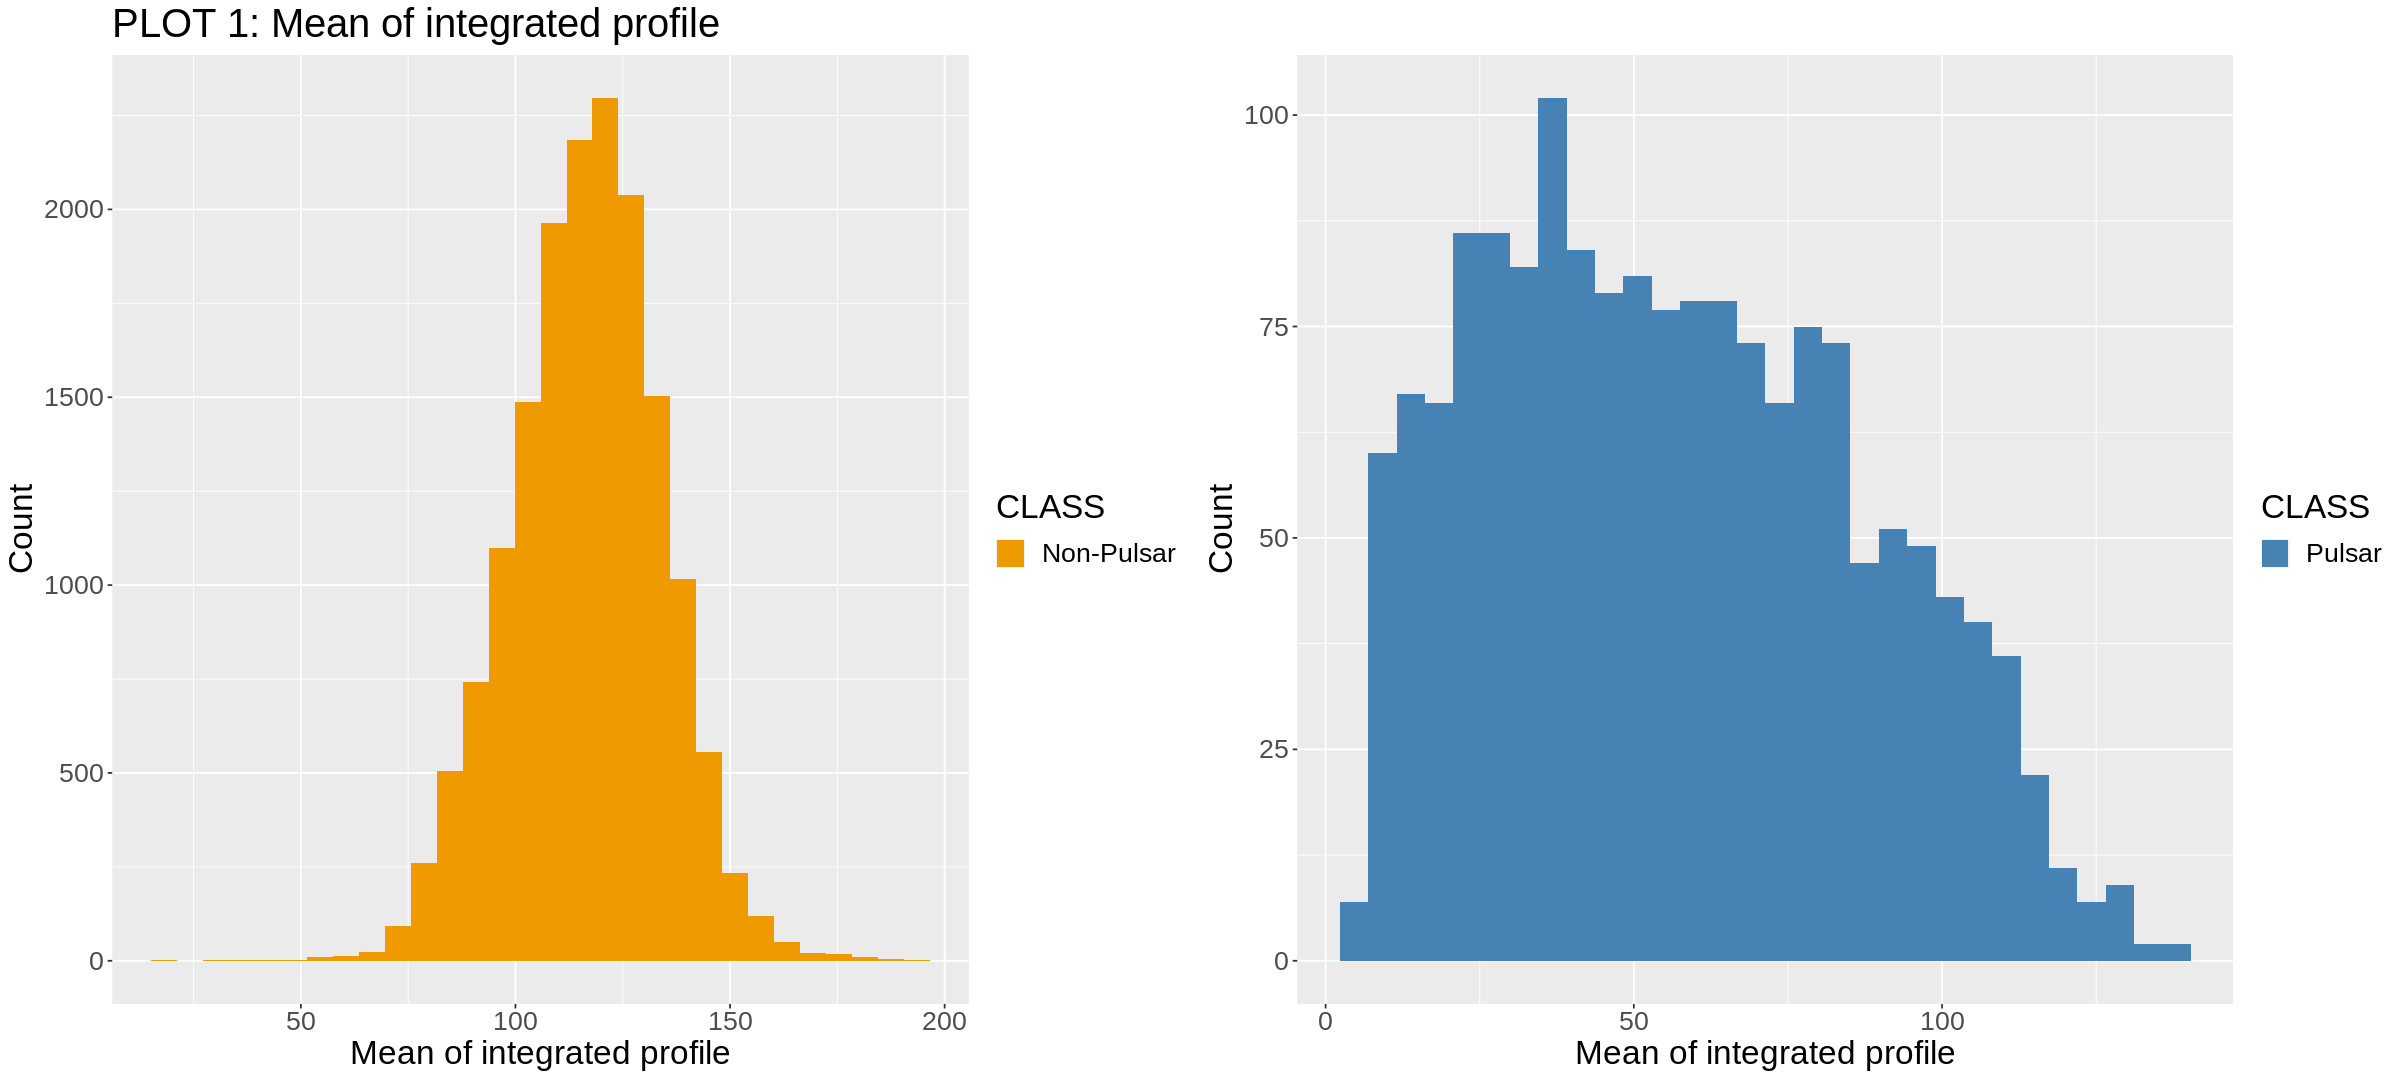

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



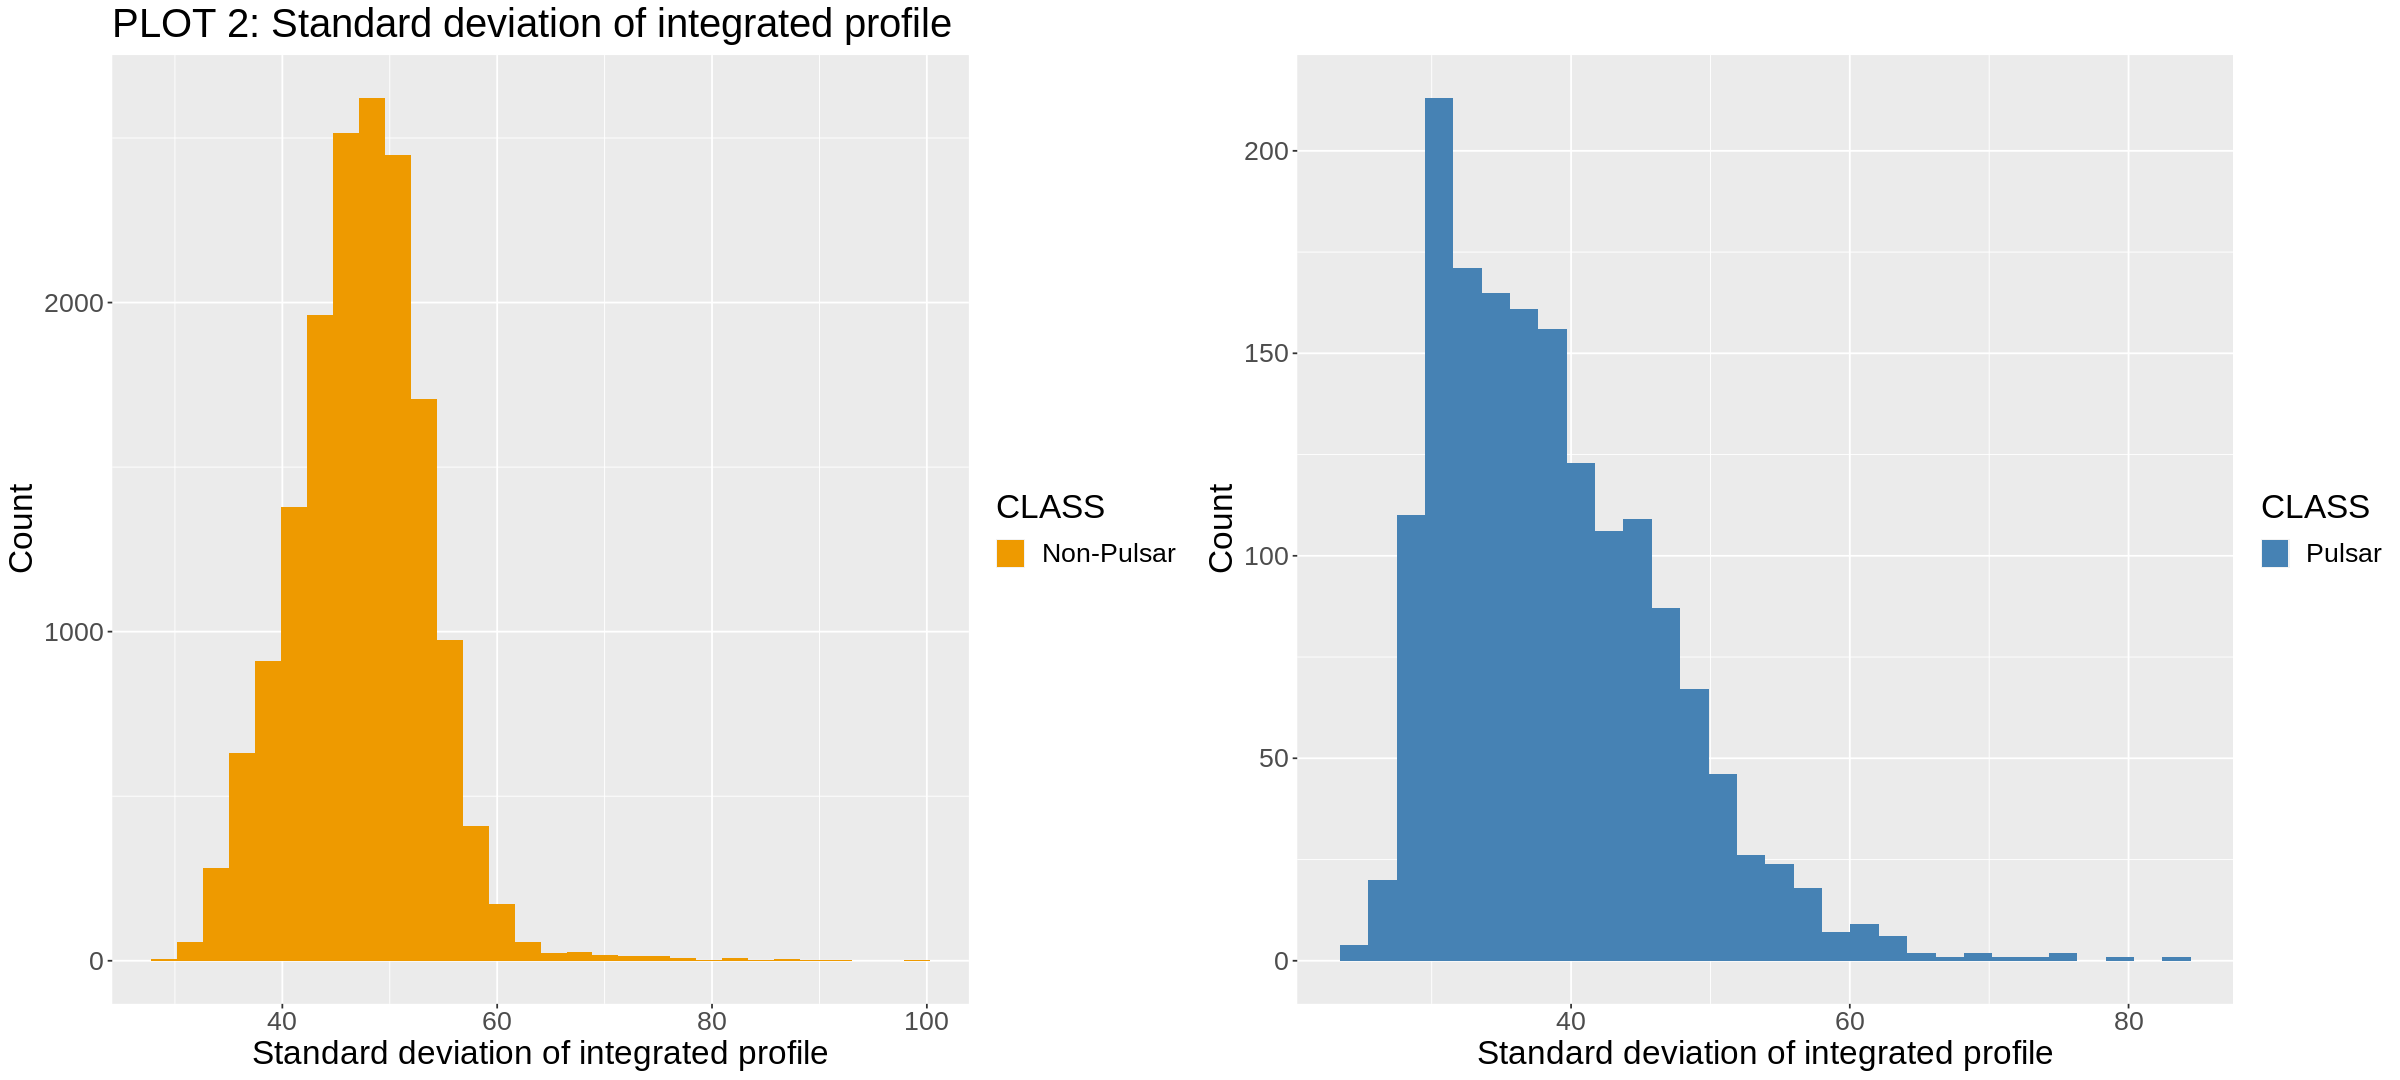

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



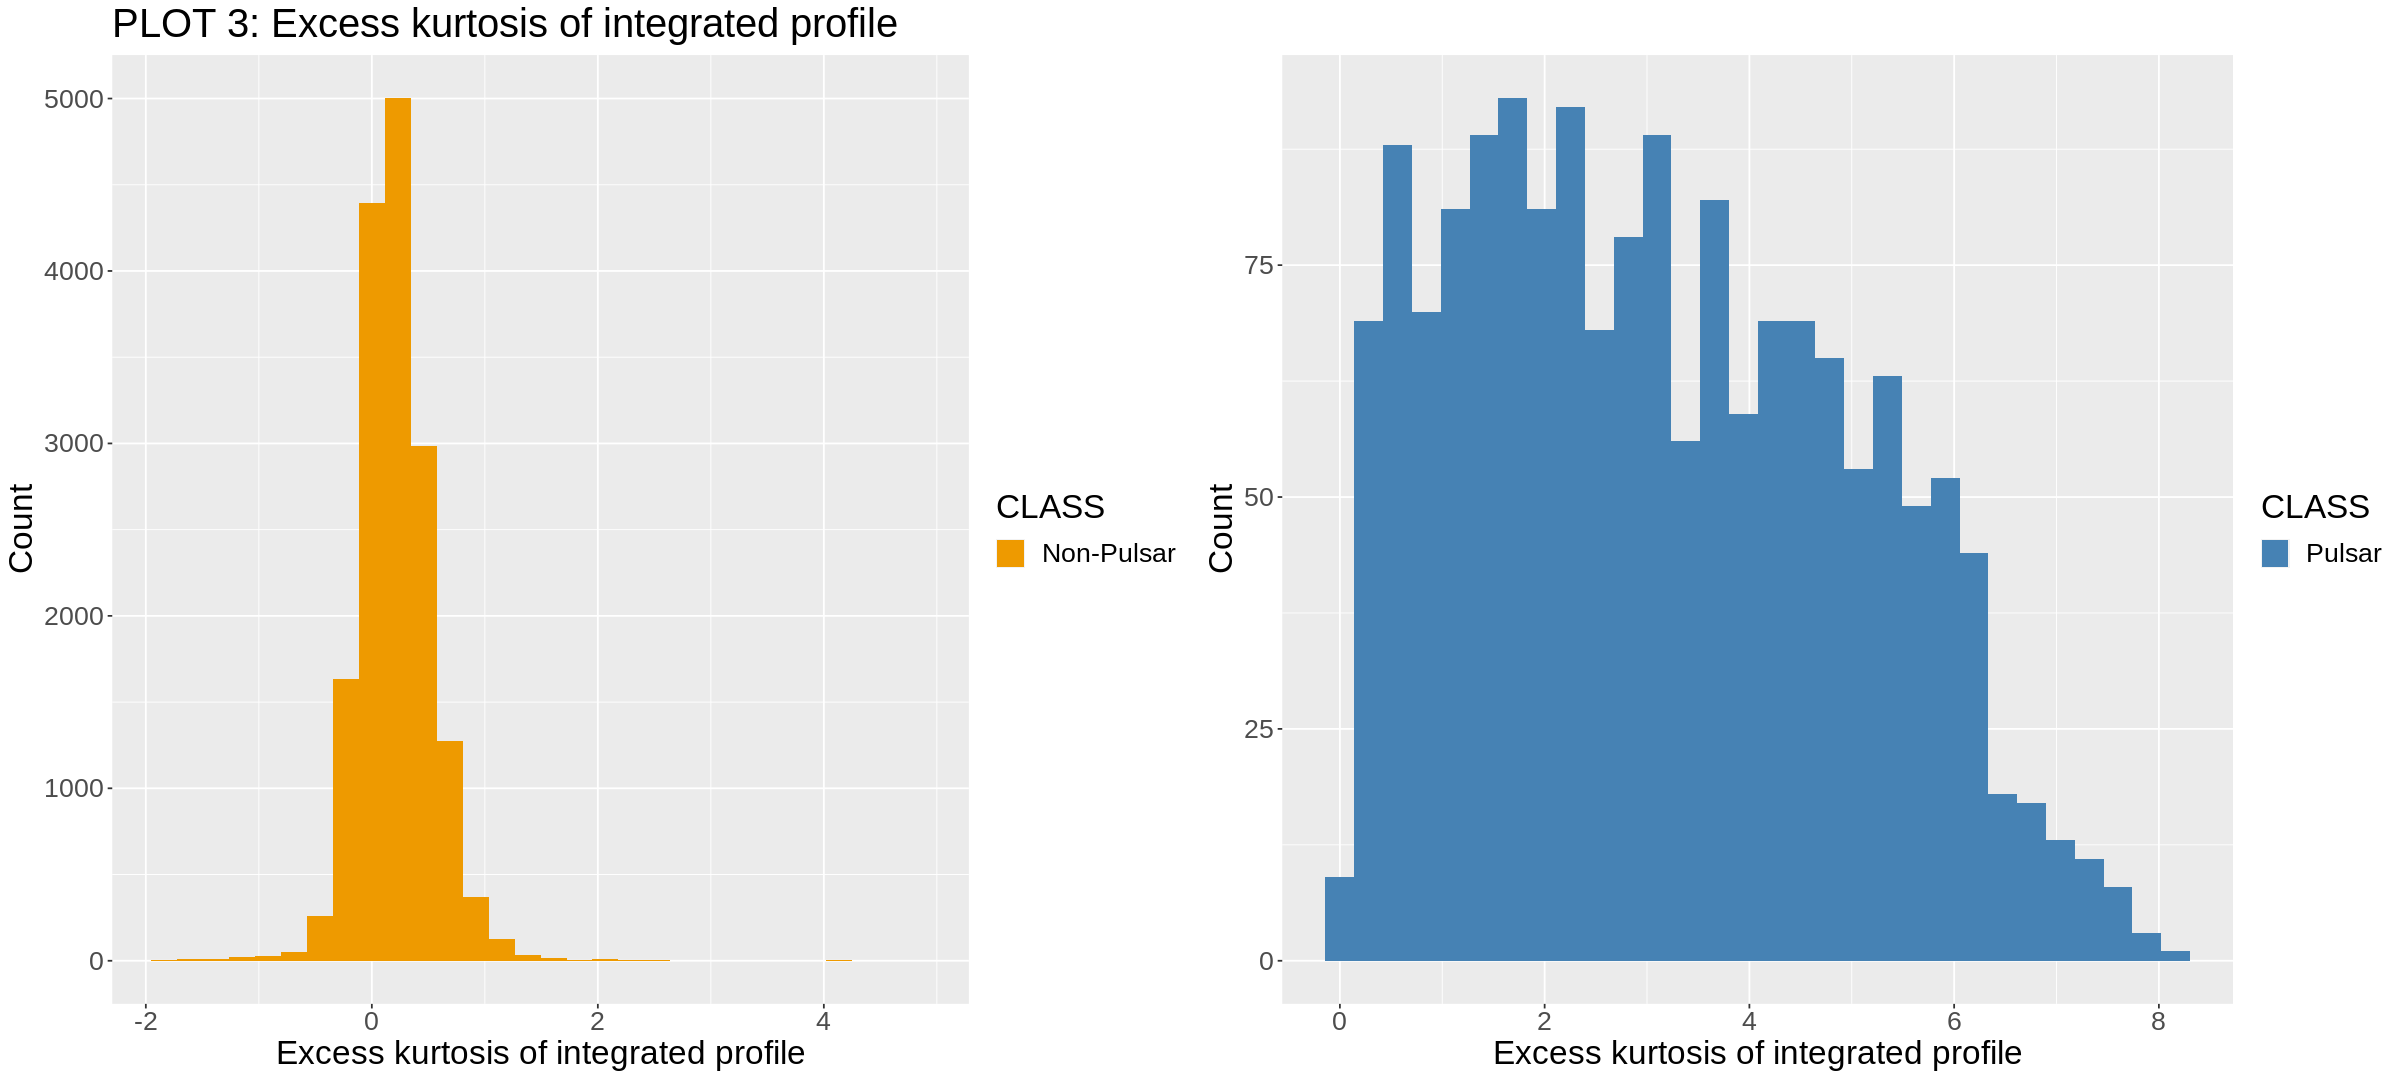

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



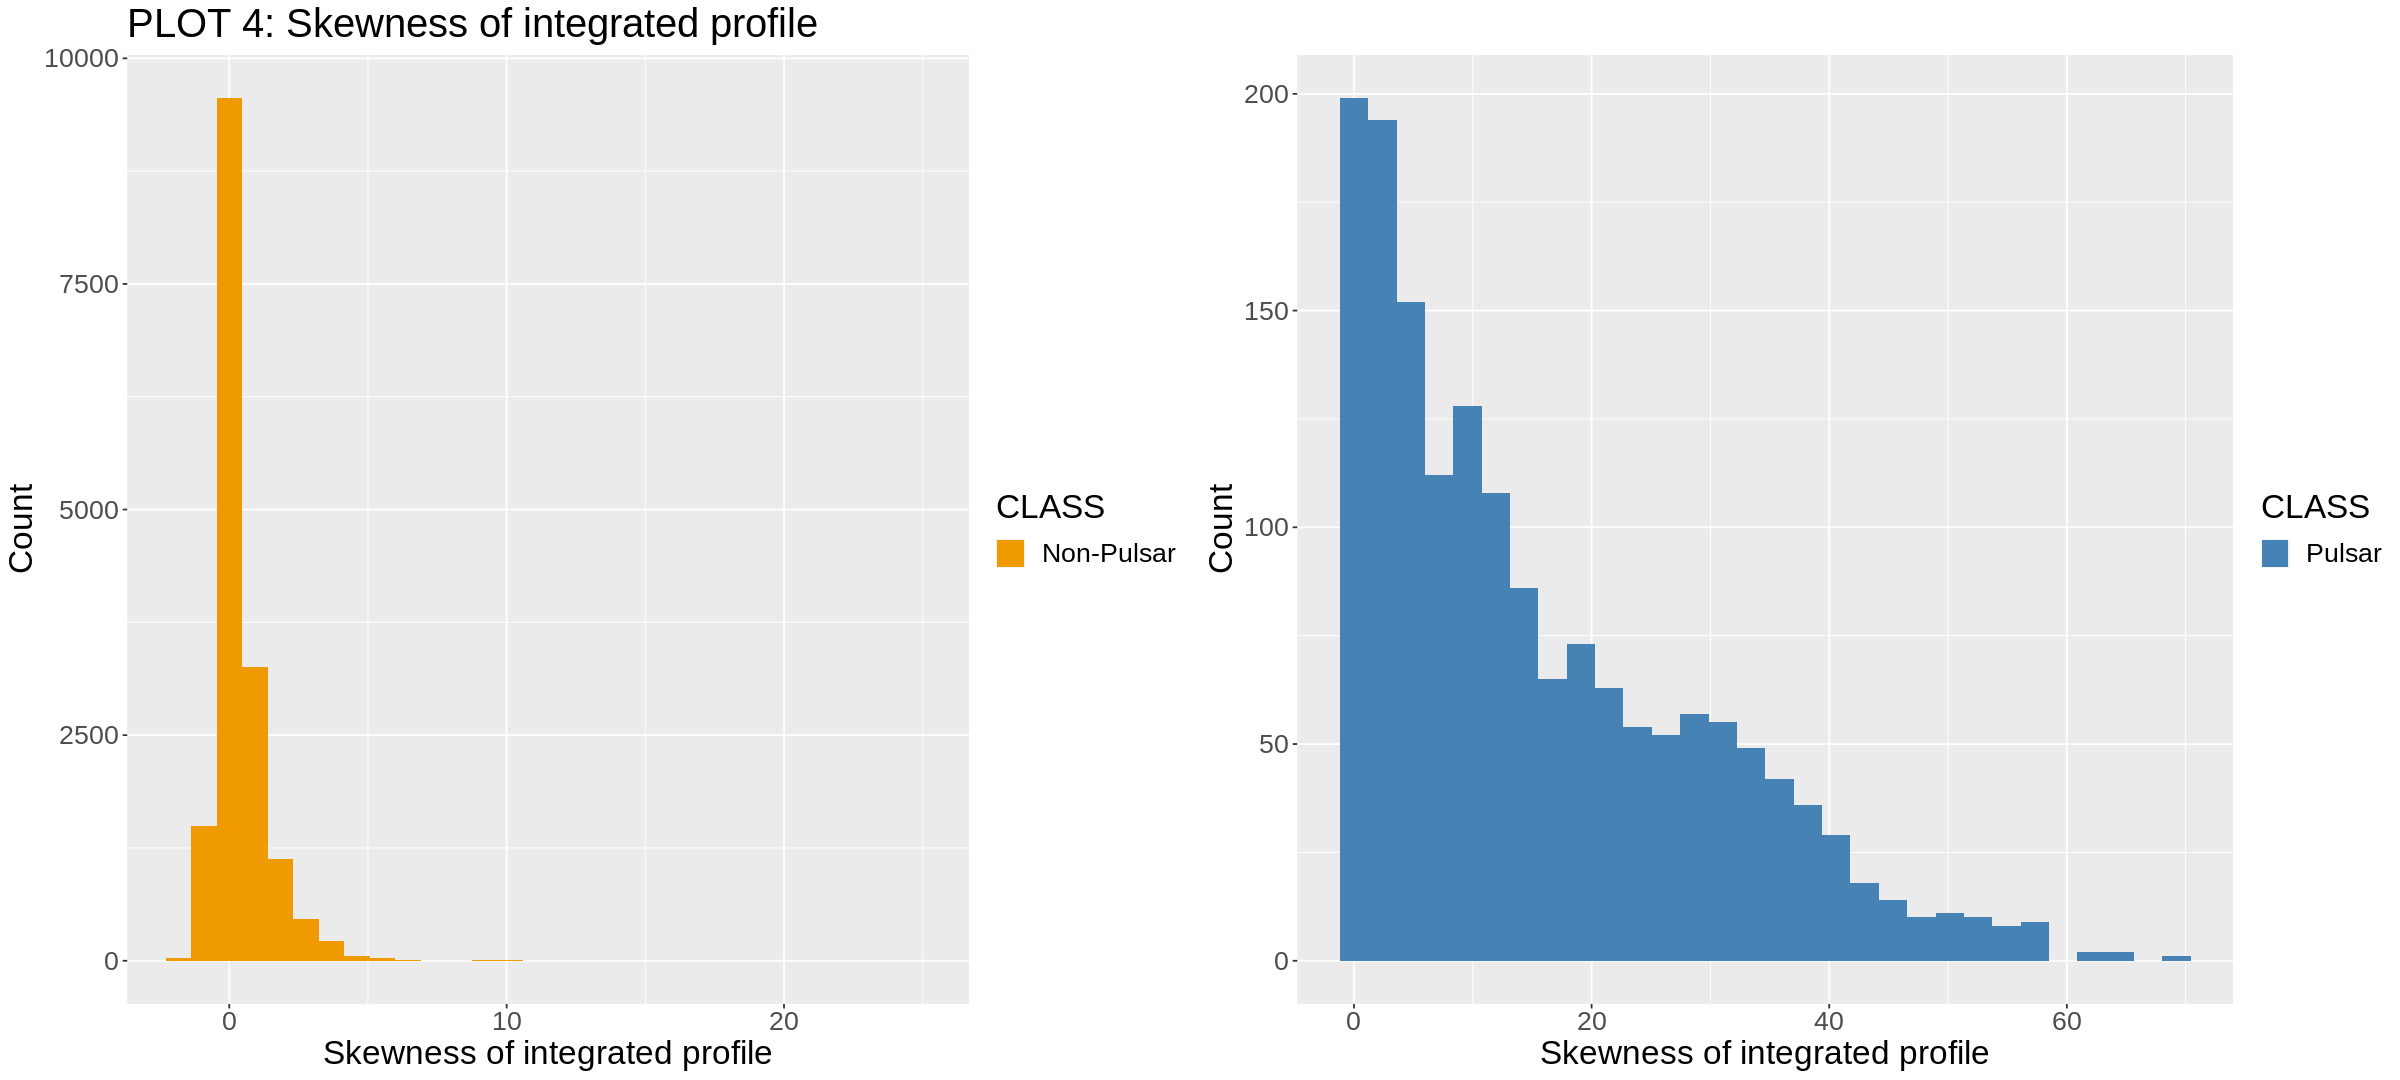

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



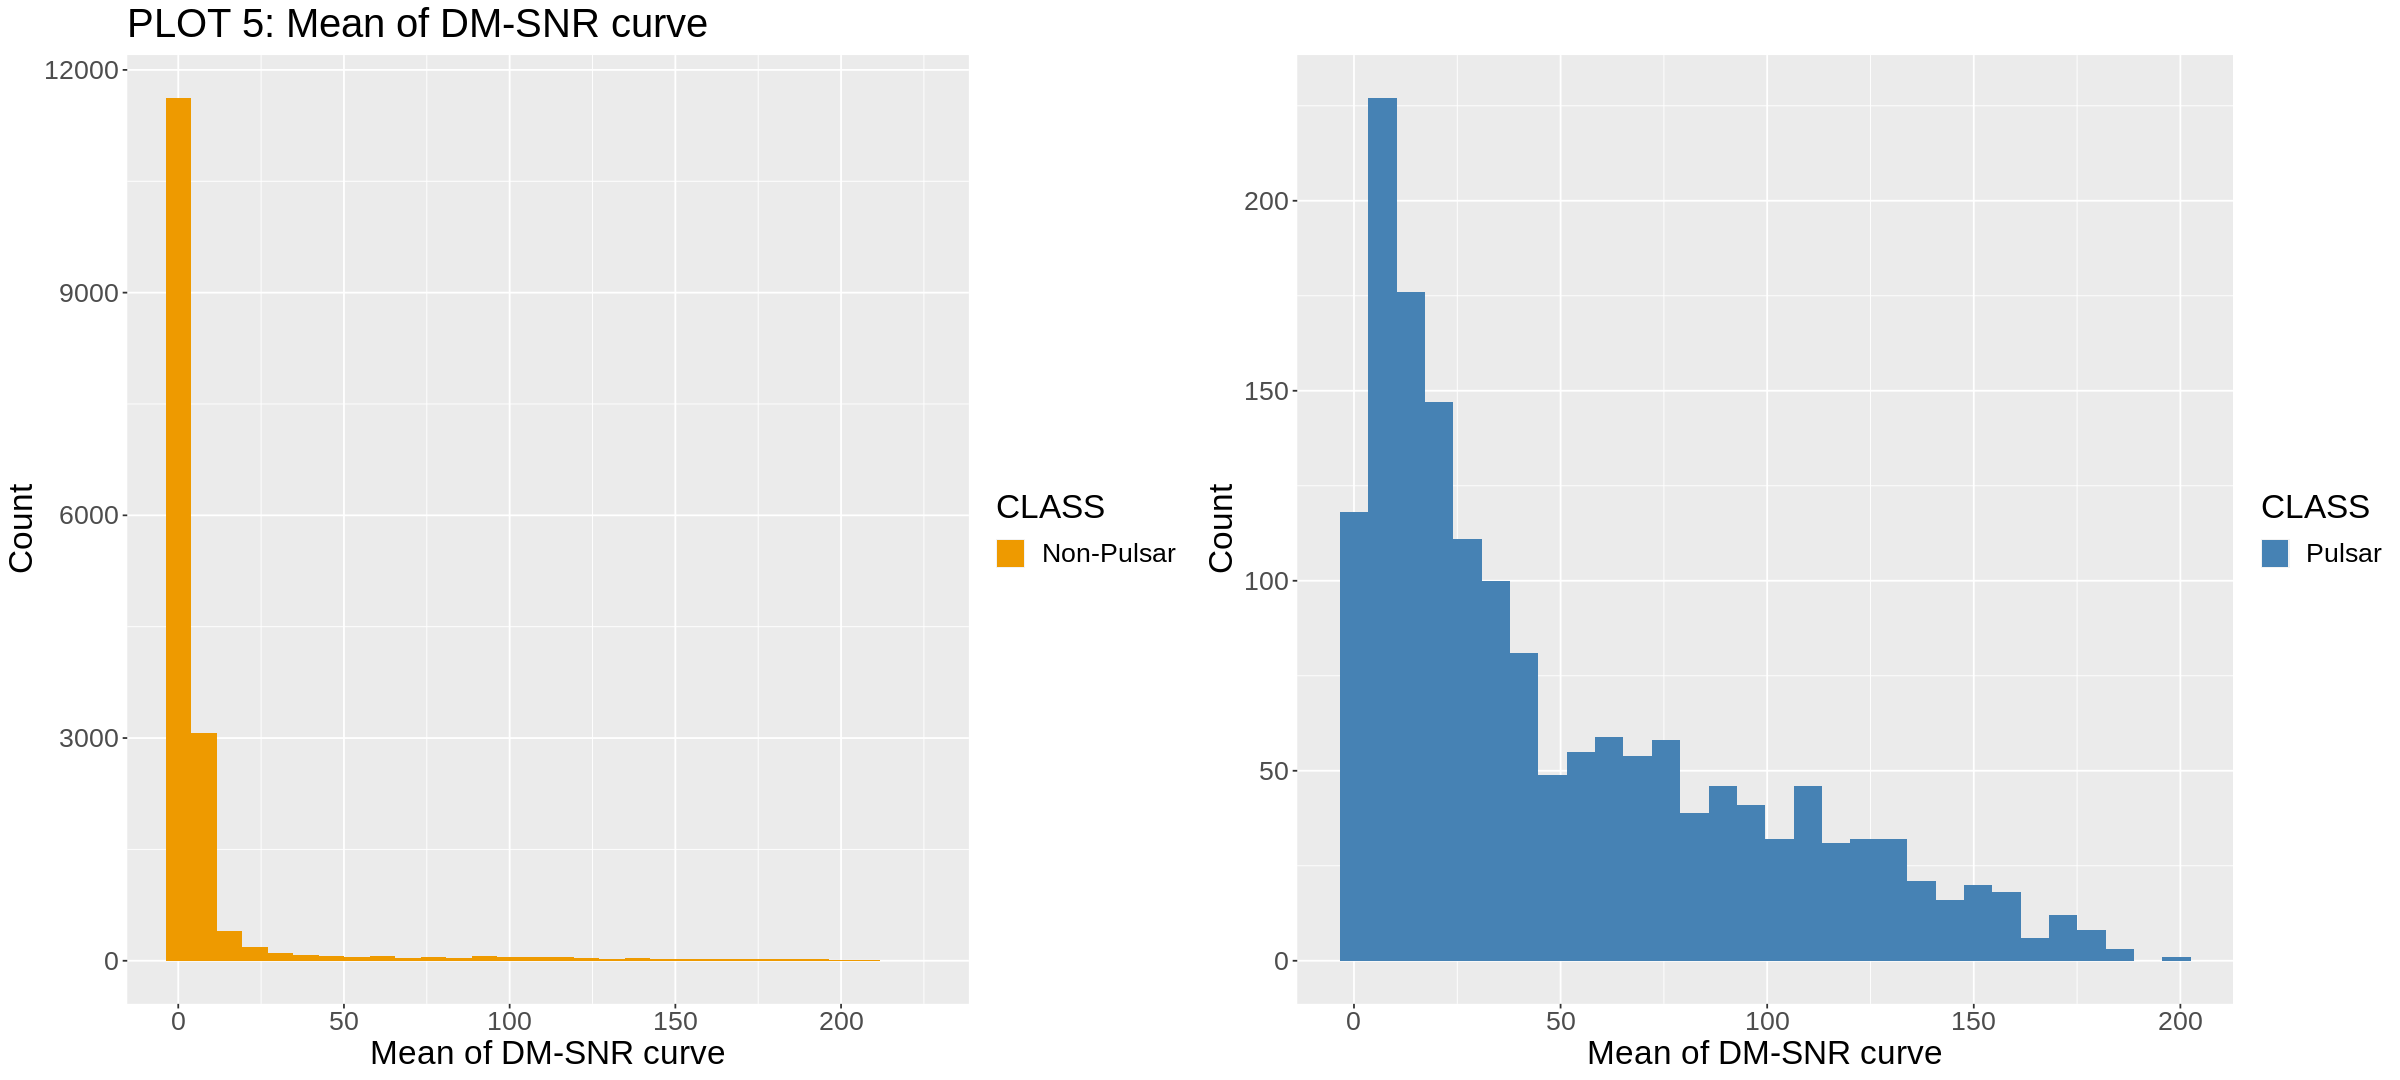

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



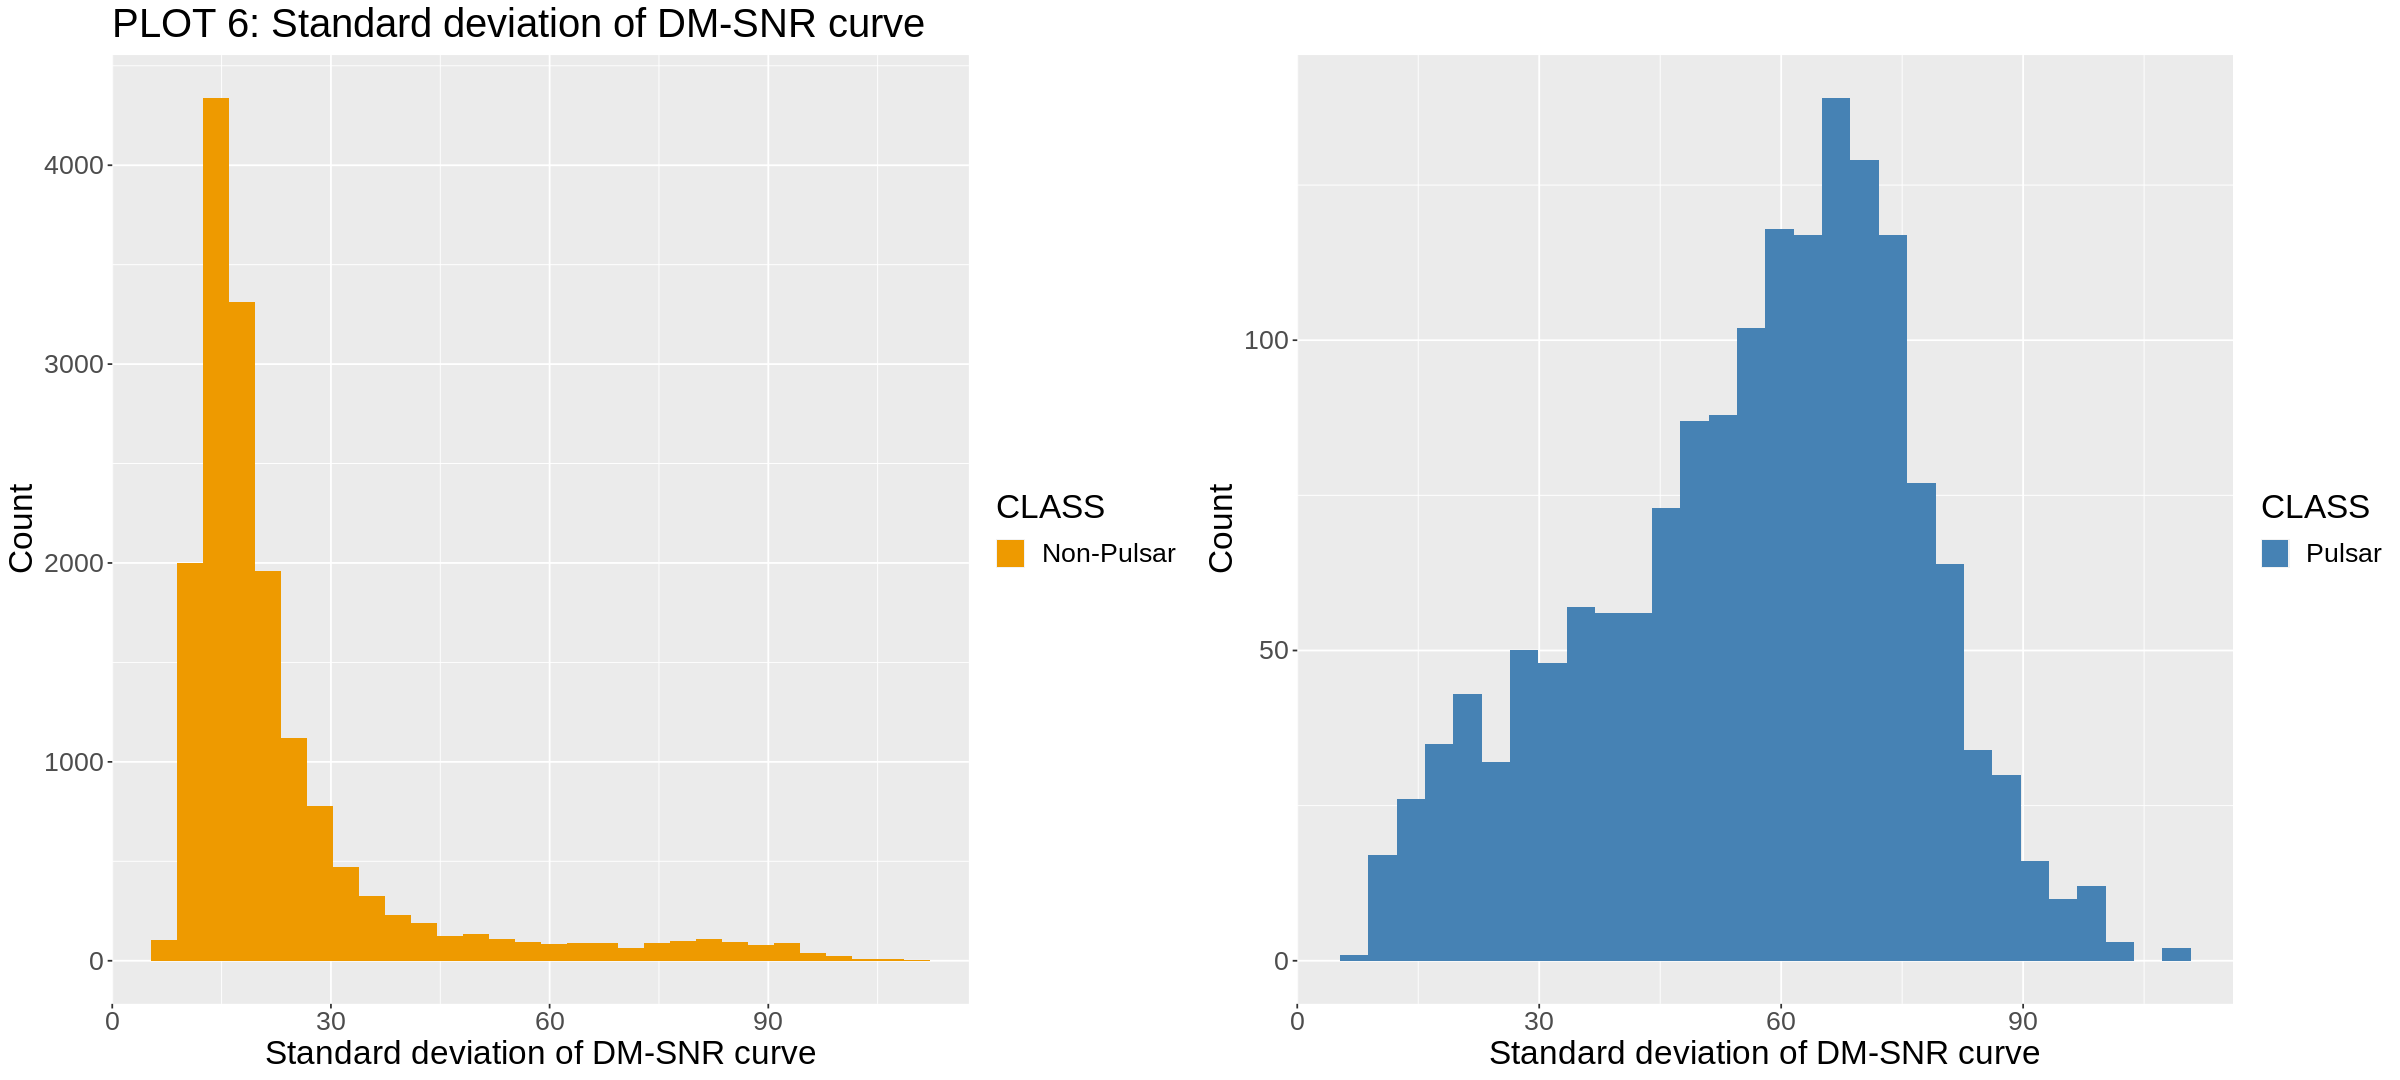

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



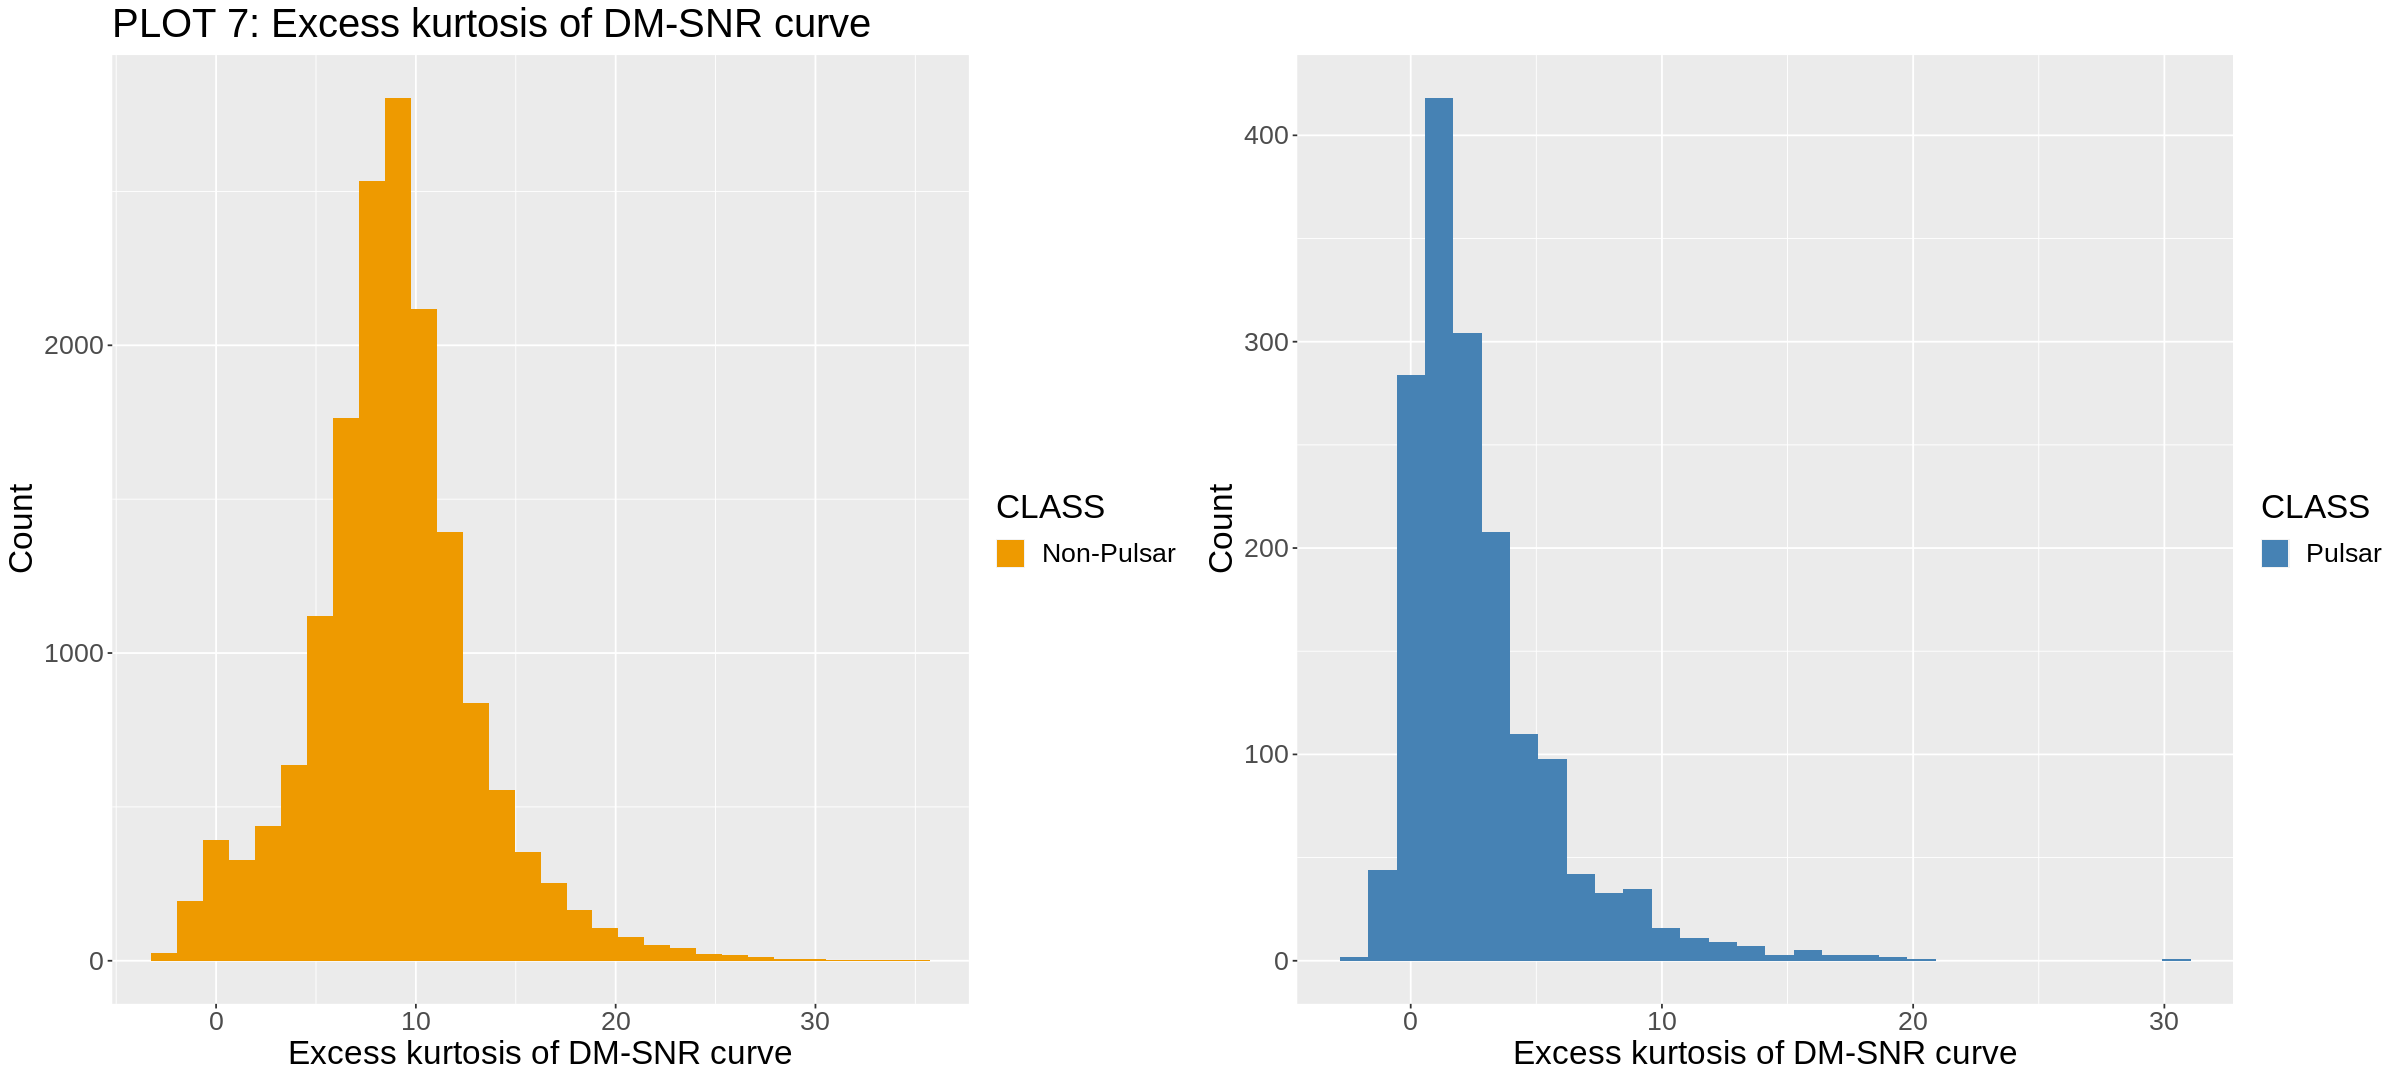

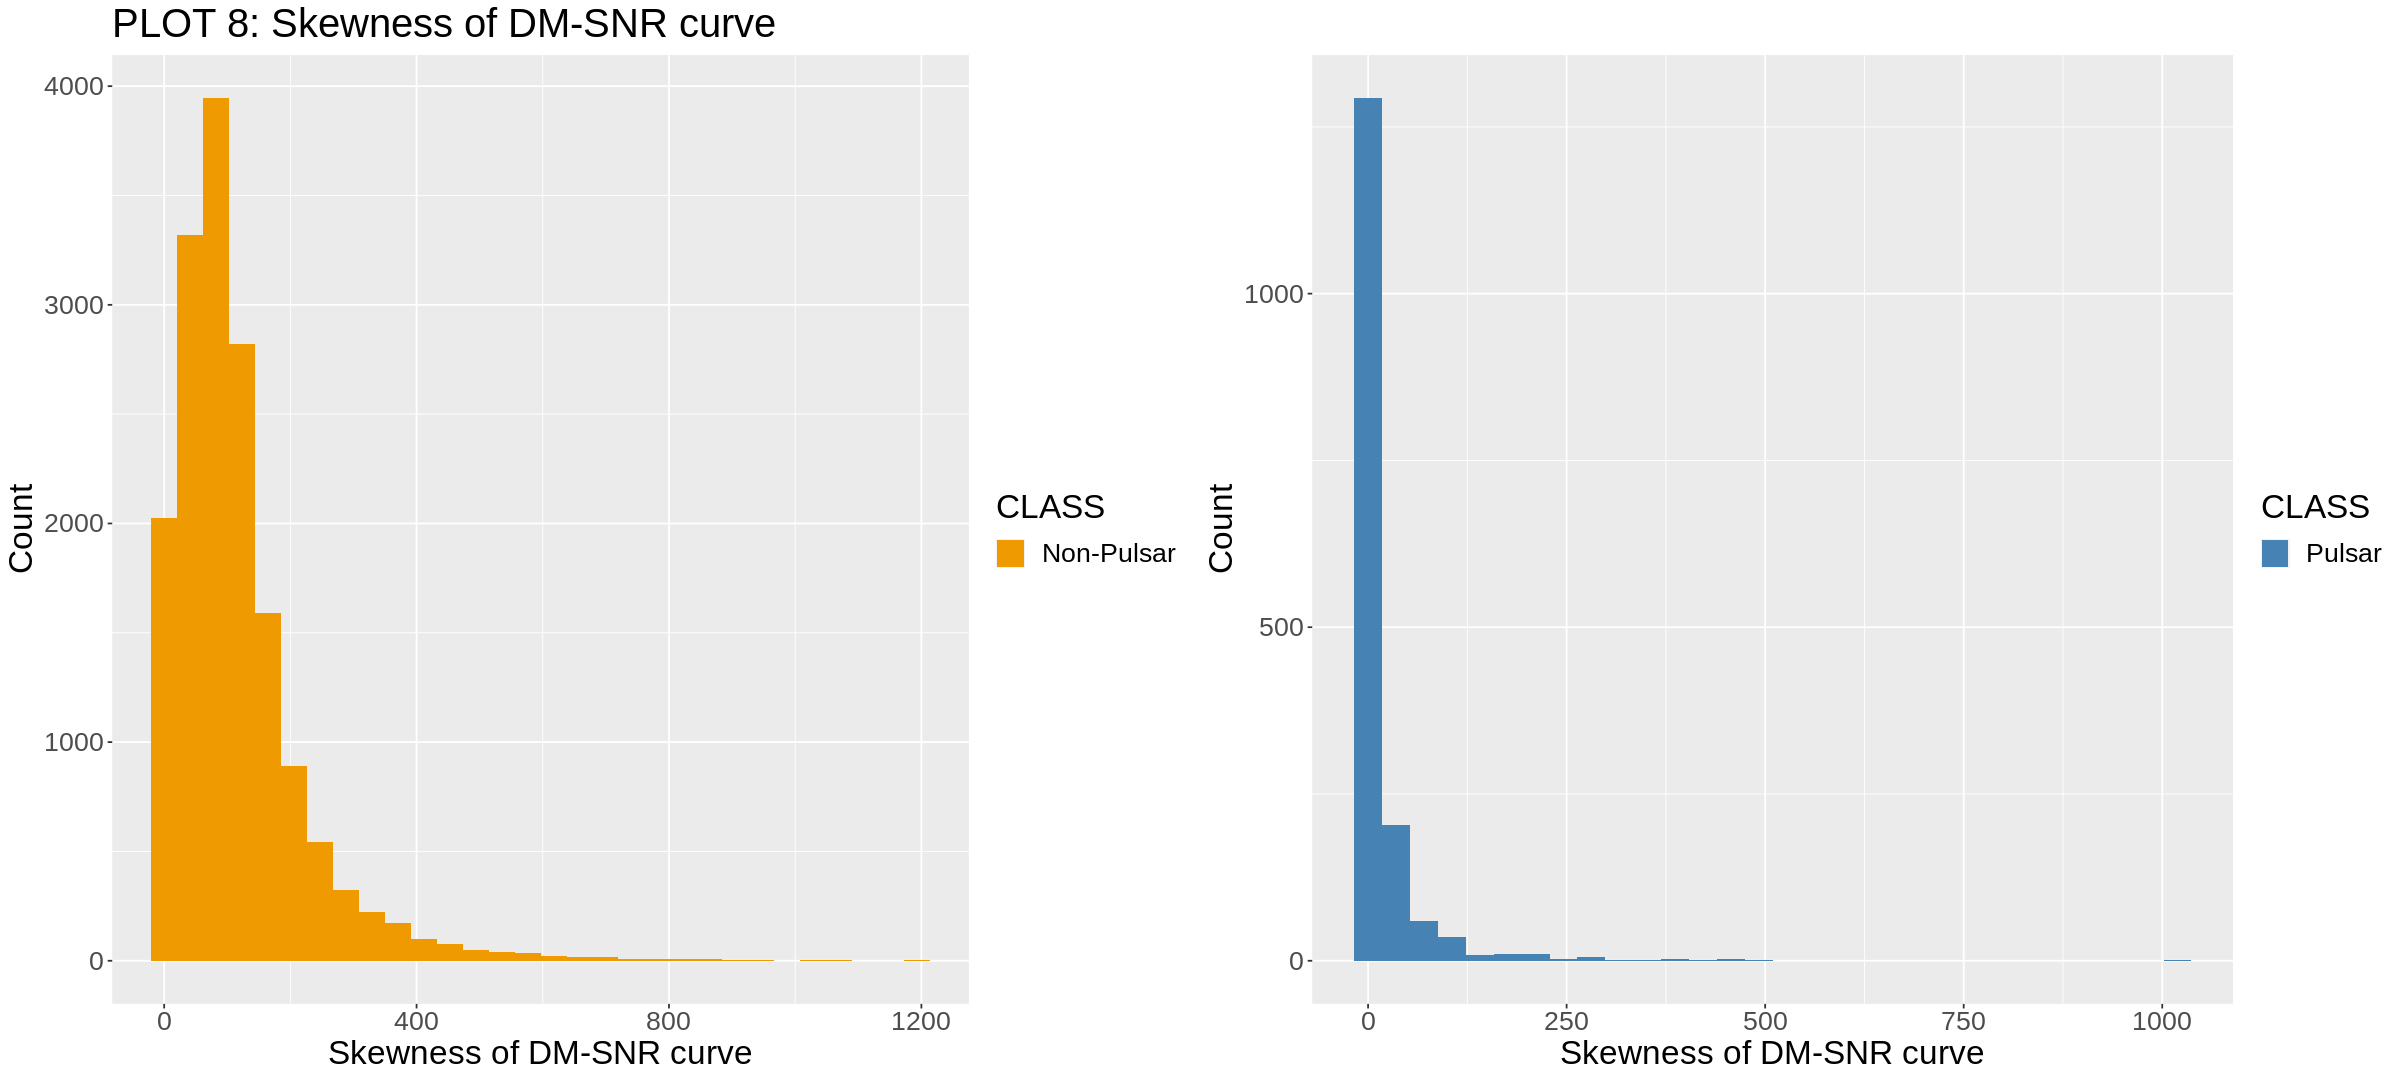

In [6]:
options(repr.plot.height = 9, repr.plot.width = 20)

pulsar_data_1 <- pulsar|>
              group_by(CLASS)|>
              select(M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS)|>
              filter(CLASS == 1)

pulsar_data_2 <- pulsar|>
              group_by(CLASS)|>
              select(M_IP,SD_IP,EK_IP,SK_IP,M_DM_SNR,SD_DM_SNR,EK_DM_SNR,SK_DM_SNR,CLASS)|>
              filter(CLASS == 0)

plot_1 <- pulsar_data_1 |>
          ggplot(aes(x = M_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_2 <- pulsar_data_2 |>
          ggplot(aes(x = M_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 1: Mean of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_2, plot_1,ncol = 2)

plot_3 <- pulsar_data_1 |>
          ggplot(aes(x = SD_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_4 <- pulsar_data_2 |>
          ggplot(aes(x = SD_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 2: Standard deviation of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_4, plot_3,ncol = 2)

plot_5 <- pulsar_data_1 |>
          ggplot(aes(x = EK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_6 <- pulsar_data_2 |>
          ggplot(aes(x = EK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 3: Excess kurtosis of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_6, plot_5,ncol = 2)

plot_7 <- pulsar_data_1 |>
          ggplot(aes(x = SK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of integrated profile", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("")+
          theme(text = element_text(size = 20))
plot_8 <- pulsar_data_2 |>
          ggplot(aes(x = SK_IP, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of integrated profile", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 4: Skewness of integrated profile") +
          theme(text = element_text(size = 20))
plot_grid(plot_8, plot_7,ncol = 2)

plot_9 <- pulsar_data_1 |>
          ggplot(aes(x = M_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_10 <- pulsar_data_2 |>
          ggplot(aes(x = M_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Mean of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 5: Mean of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_10, plot_9,ncol = 2)

plot_11 <- pulsar_data_1 |>
          ggplot(aes(x = SD_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_12 <- pulsar_data_2 |>
          ggplot(aes(x = SD_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Standard deviation of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 6: Standard deviation of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_12, plot_11,ncol = 2)

plot_13 <- pulsar_data_1 |>
          ggplot(aes(x = EK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_14 <- pulsar_data_2 |>
          ggplot(aes(x = EK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Excess kurtosis of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 7: Excess kurtosis of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_14, plot_13,ncol = 2)

plot_15 <- pulsar_data_1 |>
          ggplot(aes(x = SK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of DM-SNR curve", y = "Count", color="Pulsar")+
          scale_fill_manual(values = c("steelblue"),labels = c("Pulsar"))+
          ggtitle("") +
          theme(text = element_text(size = 20))
plot_16 <- pulsar_data_2 |>
          ggplot(aes(x = SK_DM_SNR, fill = CLASS))+
          geom_histogram()+
          labs(x = "Skewness of DM-SNR curve", y = "Count", color="Non-Pulsar")+
          scale_fill_manual(values = c("orange2"),labels = c("Non-Pulsar"))+
          ggtitle("PLOT 8: Skewness of DM-SNR curve") +
          theme(text = element_text(size = 20))
plot_grid(plot_16, plot_15,ncol = 2)

From the above plots(PLOT 1 to PLOT 8) we can see that for most variables, pulsar and non-pulsar signals tend to have different ranges of values.

Reproducibility is one of the most important features of data analysis, but randomization goes against reproducibility. Our data analysis tools use randomization, so to incorporate randomization and reproducibility in our data analysis we use the set.seed function. The set.seed function allows us to set a seed value that is used to give results that look random but are entirely reproducible if the same seed value is chosen. Another important thing to note is that jupyter notebooks are organized into cells that can run out of order, so if we run a cell which does not have a set seed our results will not be reproducible. We solve this problem by setting the seed at the start of all code cells which use randomness but choose the same seed value. Using the same seed value ensures that our analysis is unbiased and not influenced by human input.

We split the data set into training and testing data in an 80:20 ratio using the initial_split function. The initial_split function shuffles the data randomly (using seed value) before splitting, making sure that the order that the data is presented in does not influence the analysis. We also use the strata argument, setting it equal to CLASS. The strata argument stratifies the data by the CLASS label, in other words, it ensures that the proportion of pulsar and non-pulsar observations is the same in the testing and training data set as it was in the original data set.

In [7]:
set.seed(4)
pulsar_split <- initial_split(pulsar, prop = 0.8, strata = CLASS)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

Using the ggpairs function from the GGally library we get a scatterplot between all the variables. We also color the scatter points based on their label in the CLASS variable. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



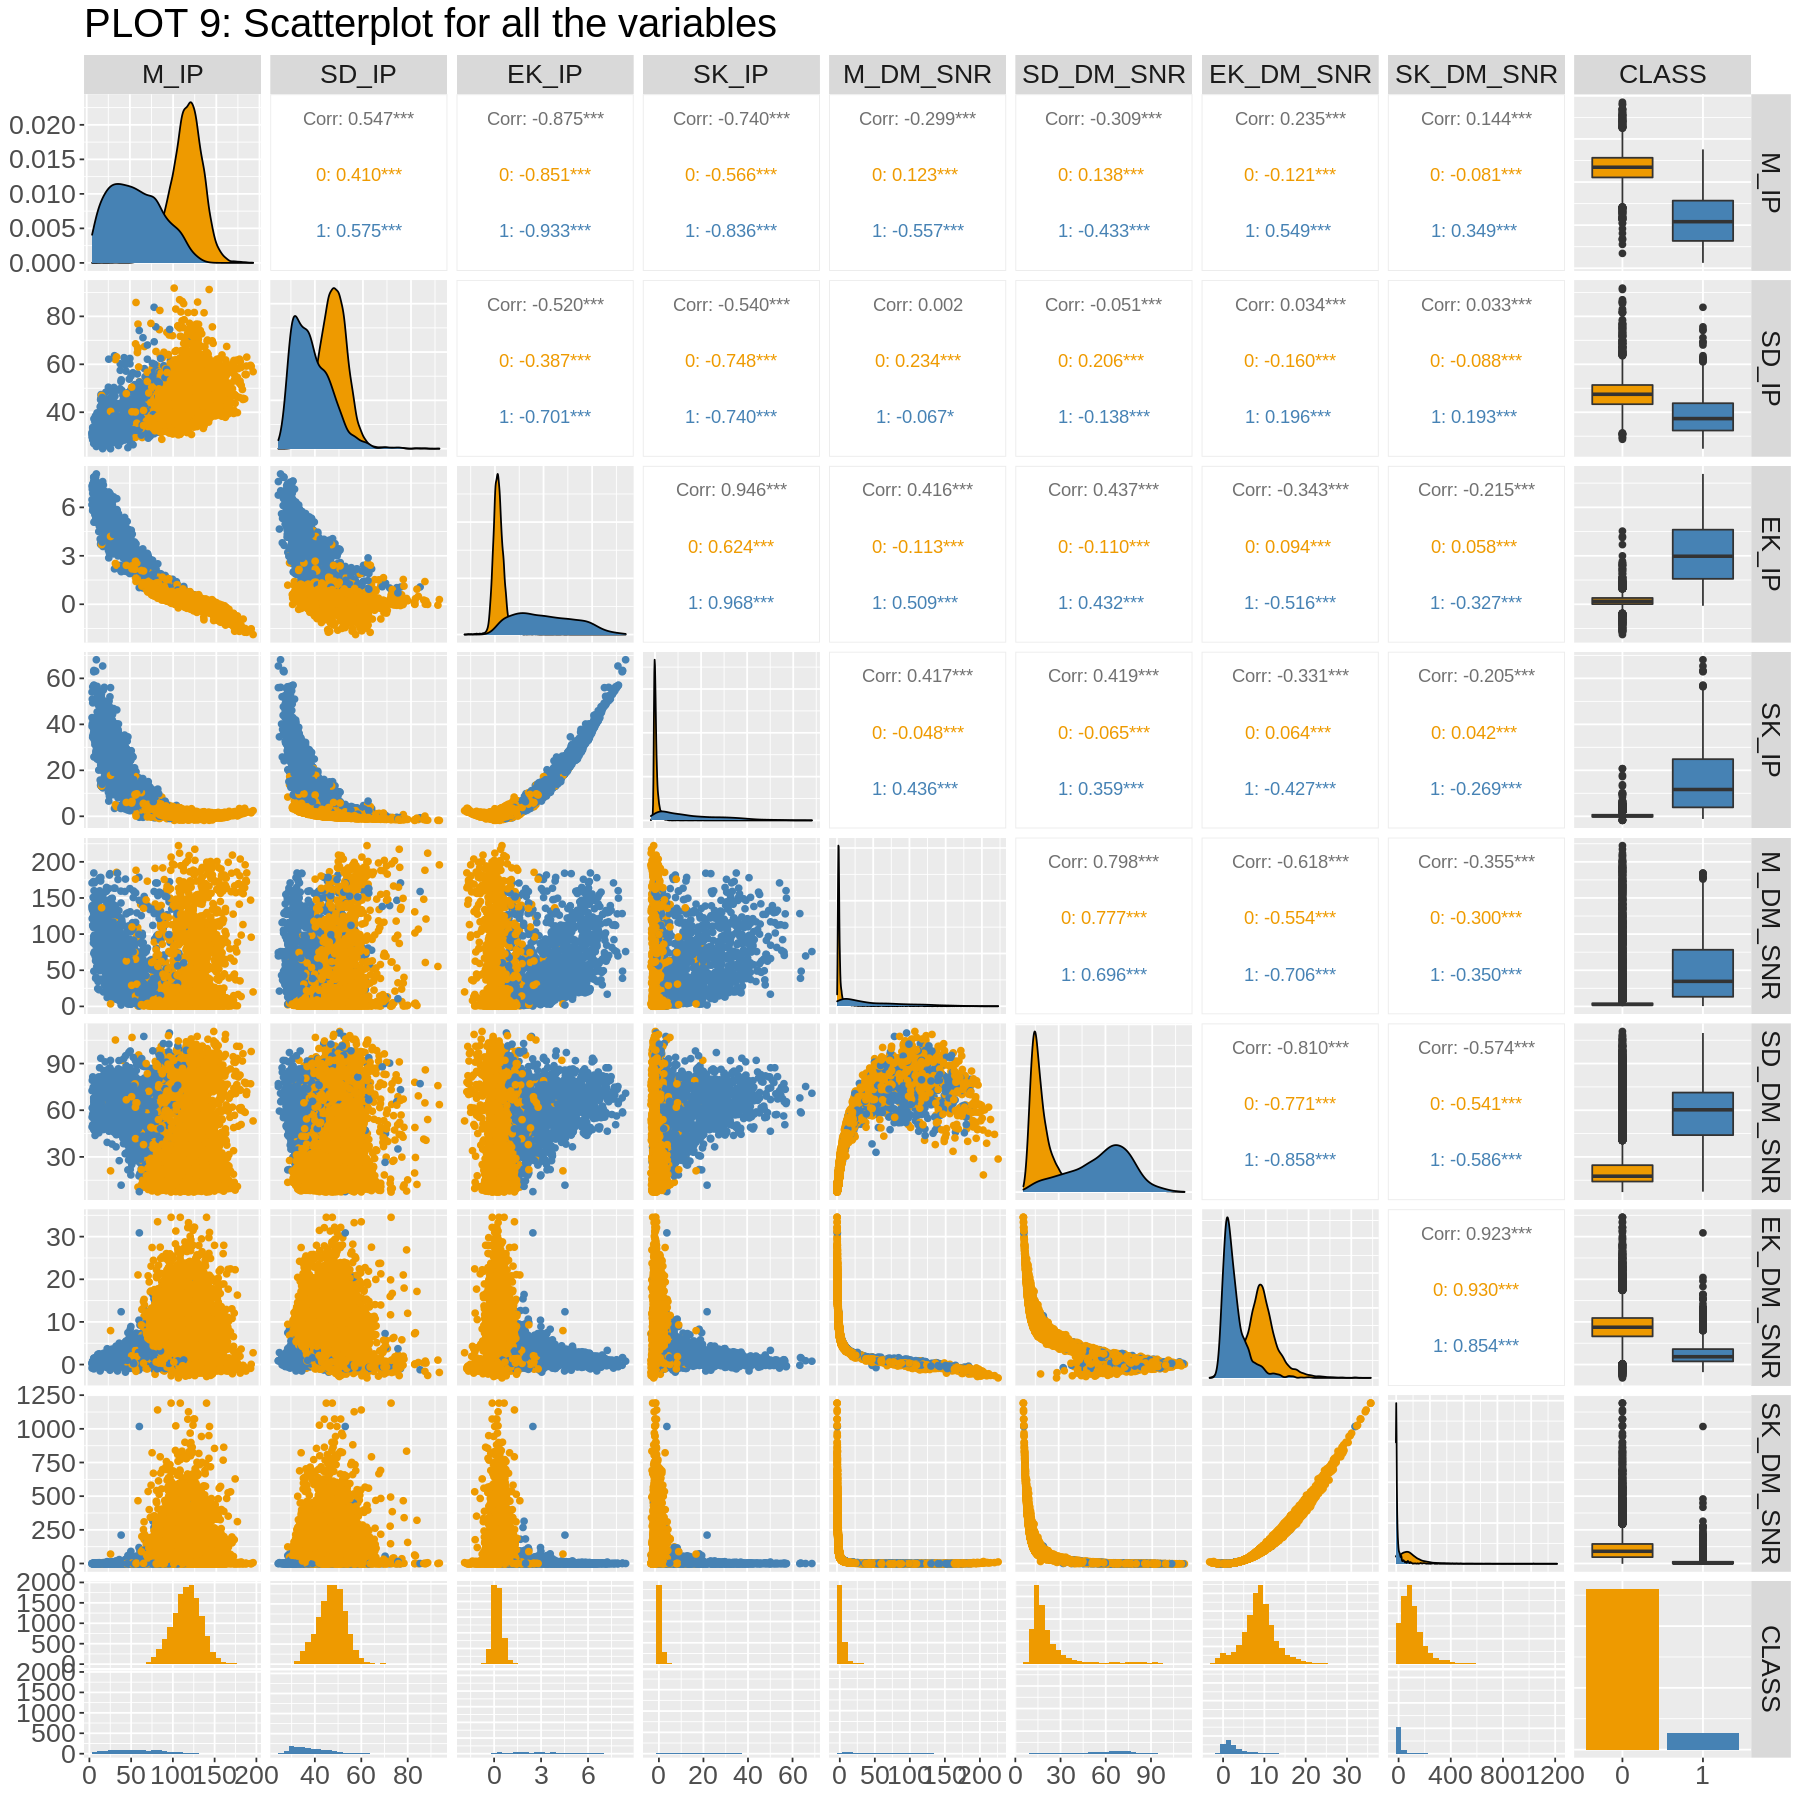

In [8]:
options(repr.plot.height = 15, repr.plot.width = 15)
pair_plot <- ggpairs(pulsar_train,aes(color = CLASS)) +
                scale_color_manual(labels = c("Non-pulsar", "Pulsar"),
                                  values = c("orange2", "steelblue")) +
                scale_fill_manual(labels = c("Non-pulsar", "Pulsar"),
                                  values = c("orange2", "steelblue")) +
                ggtitle("PLOT 9: Scatterplot for all the variables") +
                theme(text = element_text(size = 20))
pair_plot

The graph above(PLOT 9) shows us that pulsar and non-pulsar observations are separated into different clusters for most of the variables. Having this separation means that a new observation can be easily classified. But from these scatterplots, it is difficult to determine which variables might be the best predictors for our classification model. Often all the variables are not relevant predictors for our data analysis. In our case, a relevant predictor is a variable that has a meaningful relationship with the CLASS variable. Irrelevant variables can negatively affect our classification model. So, we need to find the most relevant predictors from our eight variables and use only those in our data analysis.

In [9]:
# training data is too large for forward selection so we use a smaller subset called pulsar_small_train
set.seed(4)
pulsar_train_split <- initial_split(pulsar_train, prop = 0.3, strata = CLASS)
pulsar_small_train <- training(pulsar_train_split)
pulsar_validation <- testing(pulsar_train_split)

In [10]:
nrow(pulsar_train)
nrow(pulsar_small_train)

[1] 14318

[1] 4295

To help in predictor variable selection we will use a technique known as forward selection. Forward selection is computationally expensive, so instead of using our entire training data set (which has 14318 observations), we split our training data set. We now have a small training set (containing 4295 observations) which is small enough to run forward selection on.

In forward selection, we start with no predictors and then iteratively add those predictors to our model that give the highest estimated accuracy using cross-validation. To implement this, we use two for loops. The first for loop increases the number of predictor variables (for (i in 1:length(names))). The second for loop keeps track of which variable we need to add (for (j in 1:length(names))). For a set of predictors, we run a 5-fold cross-validation to find the best K value (from 1 to 10). Using the most optimal K value, we run a 5-fold cross-validation to get the estimated accuracy for a given set of predictors. We add those predictor variables where this estimated accuracy is maximised. We extract the variables from our data and store them in the object names. We make a tuned model specification by setting neighobors equal to tune(). For each set of predictor variables, we will create a new recipe using the small training data but using a new formula; this formula is created using the paste function. For recipe preprocessing we standardize our predictors using step_center() and step_scale(). We also upsample our pulsar observations to account for the disproportionately large number of non-pulsar observations as compared to pulsar observations.

In [11]:
set.seed(4)
# forward selection will take about 10 minutes to run
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_fwd_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5 fold cross-validation object
pulsar_fwd_vfold <- vfold_cv(pulsar_small_train, v = 5, strata = CLASS)

# names of predictors
names <- colnames(pulsar_small_train |>
                     select(-CLASS)) 

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("CLASS", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_fwd_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_small_train) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors()) |>
                            step_upsample(CLASS, over_ratio = 1)

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(pulsar_fwd_recipe) |>
          add_model(knn_fwd_spec) |>
          tune_grid(resamples = pulsar_fwd_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,CLASS ~ EK_IP,0.9632130
2,CLASS ~ EK_IP+SD_IP,0.9701979
3,CLASS ~ EK_IP+SD_IP+M_DM_SNR,0.9718277
⋮,⋮,⋮
6,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR,0.9683353
7,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR,0.9683353
8,CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR+EK_DM_SNR,0.9678696


In [12]:
print(accuracies)

# A tibble: 8 × 3
   size model_string                                                    accuracy
  <int> <chr>                                                              <dbl>
1     1 CLASS ~ EK_IP                                                      0.963
2     2 CLASS ~ EK_IP+SD_IP                                                0.970
3     3 CLASS ~ EK_IP+SD_IP+M_DM_SNR                                       0.972
4     4 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP                                 0.973
5     5 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP                            0.971
6     6 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR                  0.968
7     7 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR        0.968
8     8 CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP+M_IP+SK_DM_SNR+SD_DM_SNR+EK…    0.968


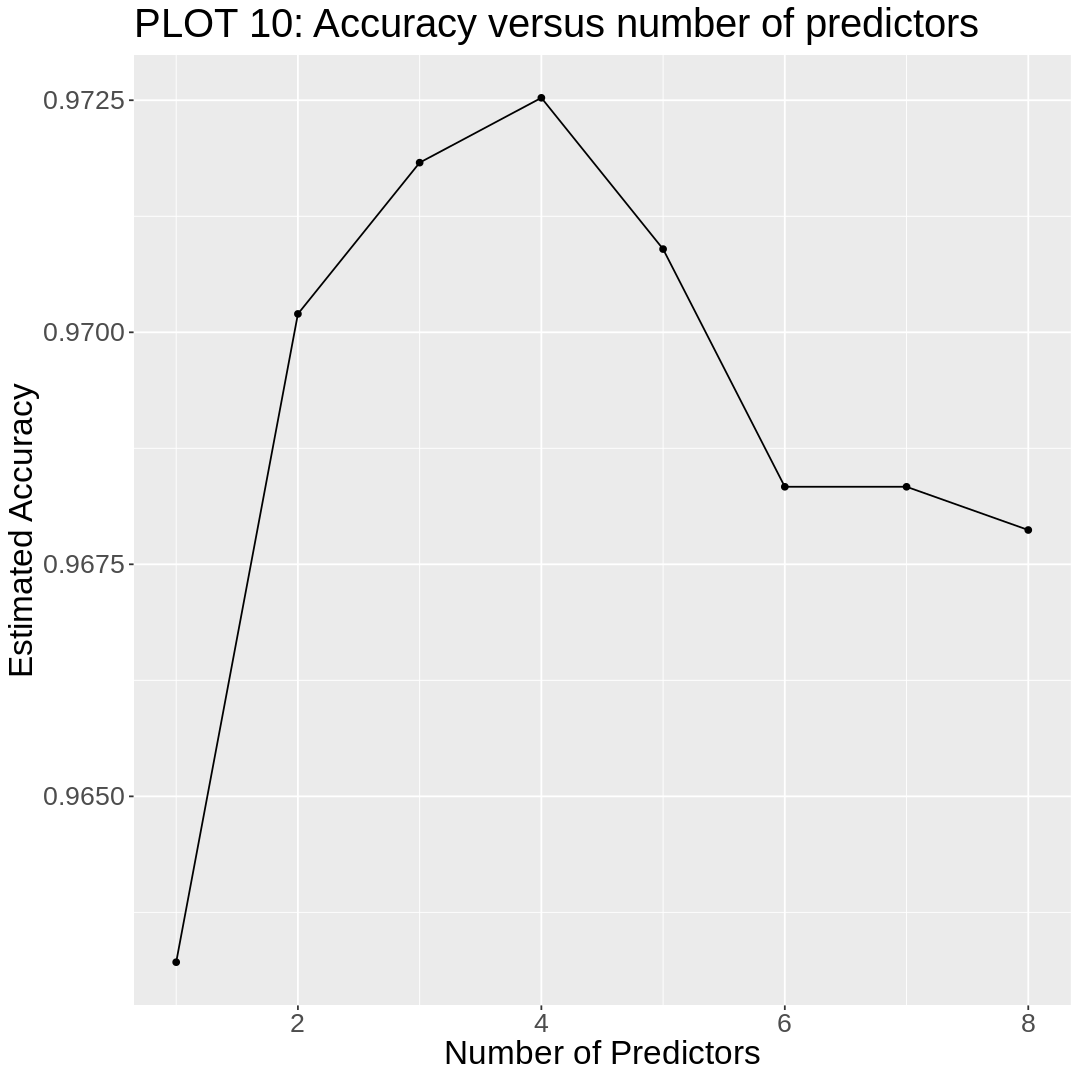

In [13]:
options(repr.plot.height = 9, repr.plot.width = 9)
accuracies_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of Predictors", y = "Estimated Accuracy") +
                    theme(text = element_text(size = 20)) +
                    ggtitle("PLOT 10: Accuracy versus number of predictors")
accuracies_plot

Using the graph (PLOT 10), we can pick the optimal number of predictors. We pick the number of predictors such that our model is simple but accurate; this would be the elbow point. At the elbow point, the accuracy is high and adding more predictors does not increase the accuracy significantly. In our graph, we get maximum accuracy at 4 which meets the simplicity and accuracy criteria. From the table, we can see that the four predictors we should use in our classification model are EK_IP, SD_IP, M_DM_SNR and SK_IP.

Before we make a classifier using our four predictors, we need to tune our model. To tune our classifier, we only have one choice of parameter: the number of neighbours K. Tidymodels provides an easy implementation of tuning using the tune() function. So we create a model specification, but instead of setting the neighbours to a specific value, we set it equal to tune(). The weight_func argument controls how the neighbors vote; setting the weight_func to "rectangular" means that each neighbor gets only one vote. We also create a recipe using the entire training data and use the four predictors from forward selection in our formula. Since the predictors are not standardized, we use step_center() and step_scale() on all predictors. Doing so makes the mean equal to 0 and the standard deviation equal to 1 for all predictor variables. This standardization is essential since algorithms such as KNN use the formula for straight-line distance, which is highly dependent on the scale of the variable.

The most important step in our recipe preprocessing is using the step_upsample function. From the exploratory analysis of our data, we saw that we had about 16000 observations for non-pulsars and about 1600 observations for pulsars. This imbalance of classes is problematic for the KNN classification algorithm. Since there is a class imbalance, our classifier is more likely to predict the majority class(non-pulsar) simply because there are more data points for that class; this is true even for observations that are similar to pulsar observations. One way to overcome class imbalance is to replicate our rare class observations. We do this by using the step_upsample function provided in the themis library. The step_upsample function requires the categorical variable to be balanced as its first argument, for us this is the CLASS variable. Setting the over_ratio equal to 1 means that after replicating the pulsar observations, the number of the pulsar and non-pulsar observations will be equal.

We perform 5-fold cross-validation for a range of K values; this gives us the mean accuracy across all folds for all K values. The mean accuracy using 5-folds is a better estimate of model accuracy than if we had just used 1-fold because multiple folds will reduce problems due to unlucky train validation splits. Here we have the K values ranging from 1 to 30. For this, we create a tibble with a single variable neighbor containing values from 1 to 30. To fit the workflow onto the cross-validation object for tuning, we use the tune_grid function.
We can now plot the K values vs accuracy as a line plot to find the best K value.


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9709457,5,0.0009709794,Preprocessor1_Model01
2,accuracy,binary,0.9709457,5,0.0009709794,Preprocessor1_Model02
3,accuracy,binary,0.9643109,5,0.0014860142,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.9585833,5,0.001954190,Preprocessor1_Model28
29,accuracy,binary,0.9592819,5,0.001666928,Preprocessor1_Model29
30,accuracy,binary,0.9592819,5,0.001666928,Preprocessor1_Model30


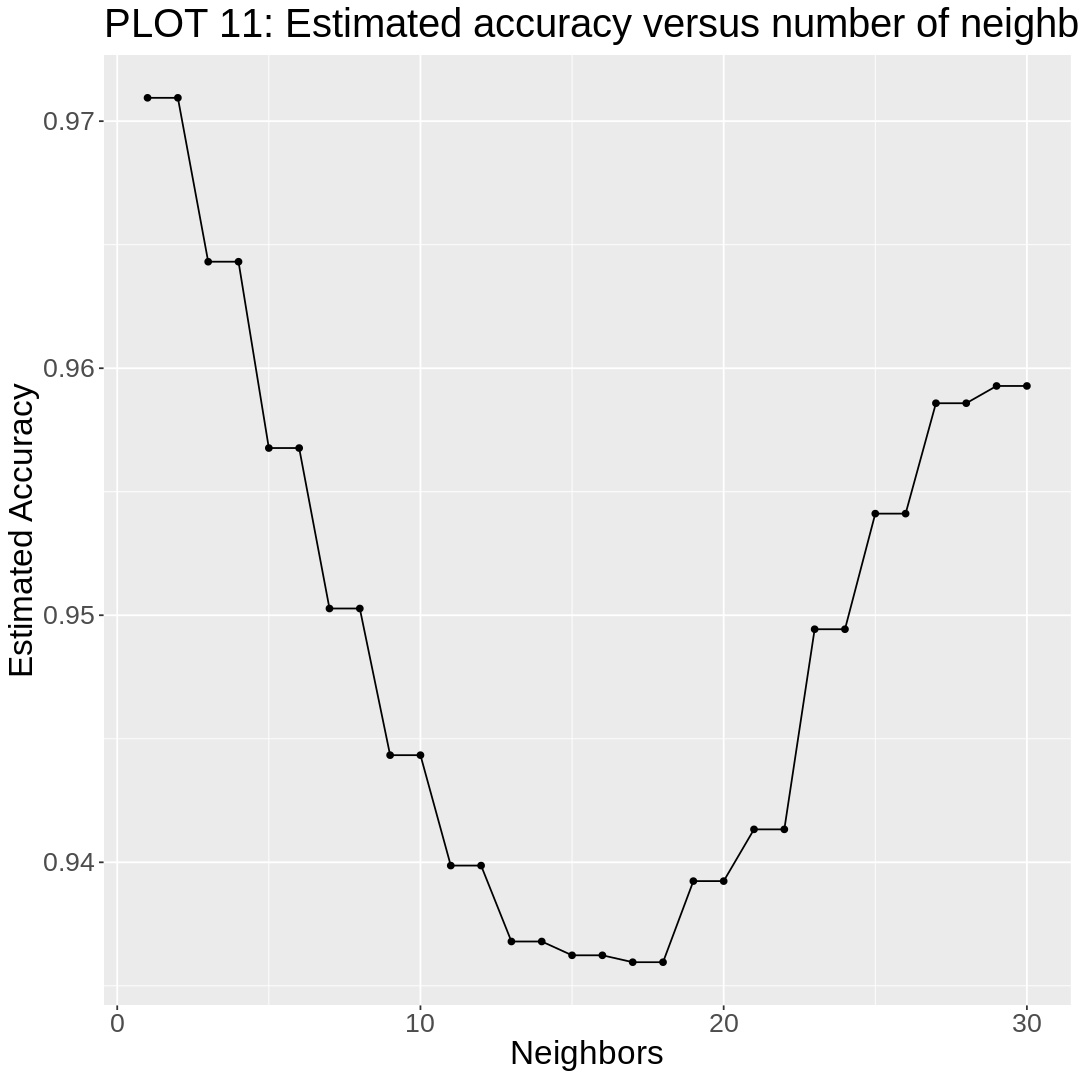

In [14]:
set.seed(4)
options(repr.plot.height = 9, repr.plot.width = 9)
# create a model specification
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

# create a model recipe using the predictor variables as given from forward selection
pulsar_recipe_tune <- recipe(CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP, data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(CLASS, over_ratio = 1)

# make a 5 fold cross-validation object using entire training dataset
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = CLASS)

# grid of neighbor values
grid_vals <- tibble(neighbors = seq(1:30))

# fit the model onto the training data and collect estimated accuracy vs neighbors data
pulsar_eaccuracy <- workflow() |>
                add_recipe(pulsar_recipe_tune) |>
                add_model(knn_tune_spec) |>
                tune_grid(resamples = pulsar_vfold, grid = grid_vals) |>
                collect_metrics() |>
                filter(.metric == "accuracy")
pulsar_eaccuracy

estimate_accuracy_vs_k <- ggplot(pulsar_eaccuracy, aes(x = neighbors, y = mean)) +
                            geom_point() +
                            geom_line() +
                            labs(x = "Neighbors", y = "Estimated Accuracy") +
                            theme(text = element_text(size = 20)) +
                            ggtitle("PLOT 11: Estimated accuracy versus number of neighbors")
estimate_accuracy_vs_k

To find the best K value it should meet certain criteria:
1) We get roughly optimal accuracy so that our model will likely be accurate.

2) Changing the K value to a neighboring one doesn’t vary the accuracy too much.

3) The cost of training the model is not prohibitively expensive (K is not too large)

We have chosen 3 as the most optimal K value since it meets the above-listed criteria (PLOT 11).

The relatively high accuracy of the classifier at a K value of 30 is not surprising, considering the large size of the data set. This data set has about 16200 observations, so a K value of 30 might not be very high. The general trend of decreasing accuracy with increasing K value that we typically observe might lie at even higher K values. We chose to pick a lower K value since a high K value would be computationally expensive.


We create a new model specification setting the number of neighbors to 3. We still want all neighbors to have equal votes so we set weight_func to “rectangular”. The recipe still has the training data and uses the 4 predictors from forward selection. For preprocessing in the recipe, we standardize and upsample. We add the model specification and recipe to the workflow and fit this workflow onto the training data to give us our final classification model.

Using this model, we predict the labels for testing data observations using the predict function. We then join the predicted labels for test observations to the original test data using bind_cols(). To calculate the accuracy of our classification model, we use two metrics:

1) Prediction accuracy is the percentage of observations from the test data for which the classifier has correctly predicted the labels. To calculate prediction accuracy, we use the collect_metrics function. The truth argument takes the column containing true labels, and the prediction argument takes the column containing predicted labels which is .pred_calss.

2) We also make a confusion matrix using the conf_mat function, setting the truth and prediction arguments as done above. This confusion matrix shows us what kinds of mistakes our classifier made.


In [15]:
set.seed(4)
# create a new model specification using the best neighbor value
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
                set_engine("kknn") |>
                set_mode("classification")

# we can reuse the old recipe, but we are creating a new one so that this code block can be run seperately
pulsar_recipe <- recipe(CLASS ~ EK_IP+SD_IP+M_DM_SNR+SK_IP, data = pulsar_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(CLASS, over_ratio = 1)

# fir model onto the training data
pulsar_fit <- workflow() |>
                add_recipe(pulsar_recipe) |>
                add_model(knn_best_spec) |>
                fit(pulsar_train) 

# predict labels for test data observations and join with original table
pulsar_predict <- predict(pulsar_fit, pulsar_test) |>
                    bind_cols(pulsar_test)

# Calculate accuracy of our model predicting on testing data
pulsar_accuracy <- pulsar_predict |>
                    metrics(truth = CLASS, estimate = .pred_class)
pulsar_accuracy

# confusion matrix for our model predicting on testing data
pulsar_conf_mat <- pulsar_predict |>
                    conf_mat(truth = CLASS, estimate = .pred_class)

pulsar_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9592179
kap,binary,0.7701358


          Truth
Prediction    0    1
         0 3155   47
         1   99  279

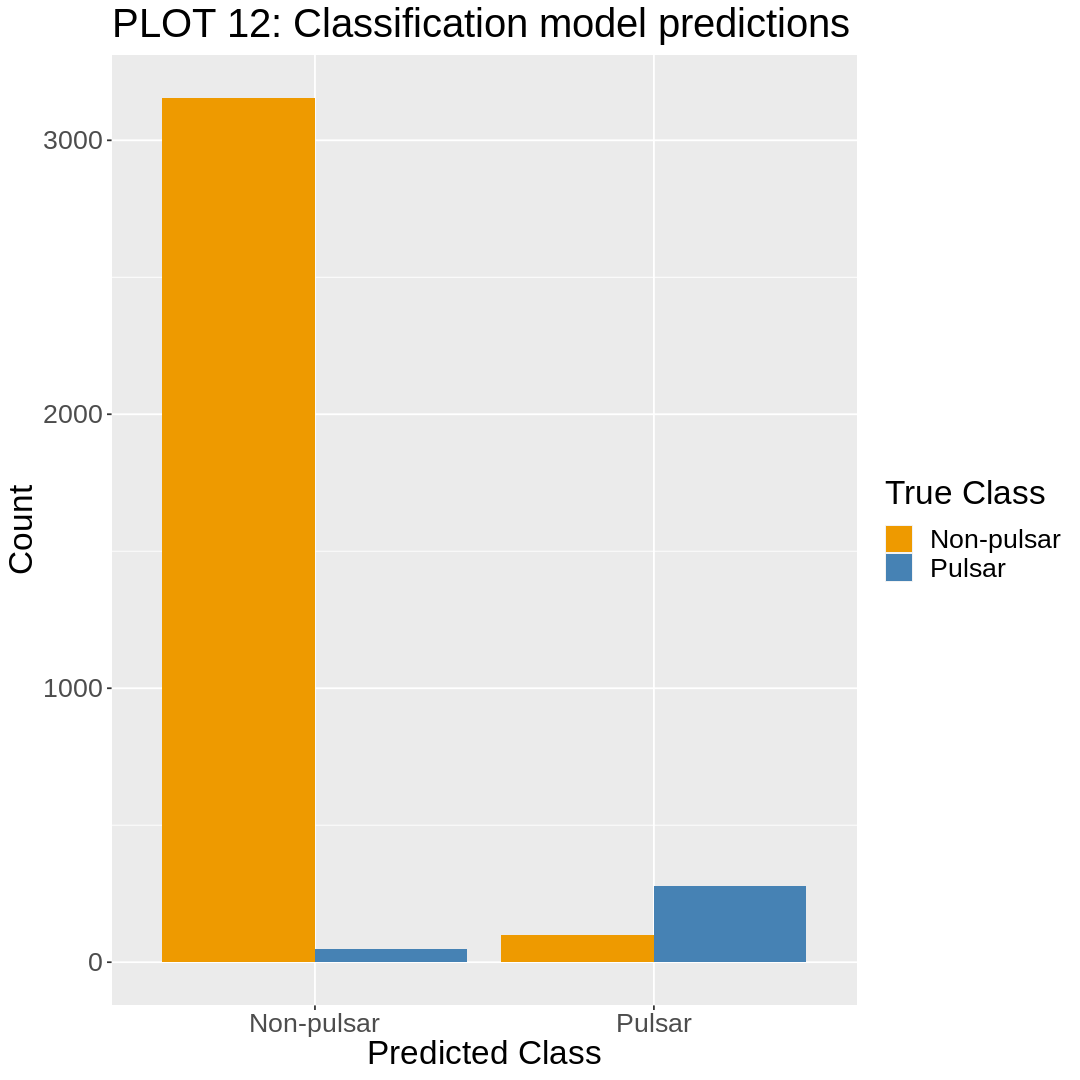

In [16]:
options(repr.plot.height = 9, repr.plot.width = 9)
confusion_matrix_data <- tibble(Prediction = (as.factor(c(0,0,1,1))),
                           Truth = (as.factor(c(0,1,0,1))),
                           count = c(3155, 47, 99, 279))
confusion_matrix_plot <- ggplot(confusion_matrix_data, aes(x = Prediction, y = count, fill = Truth)) +
                            geom_bar(stat = "identity", position = "dodge") +
                            labs(x = "Predicted Class", y = "Count", fill = "True Class") +
                            scale_fill_manual(labels = c("Non-pulsar", "Pulsar"),
                                             values = c("orange2", "steelblue")) +
                            scale_x_discrete(labels = c("0" = "Non-pulsar",
                                                       "1" = "Pulsar")) +
                            theme(text = element_text(size = 20)) +
                            ggtitle("PLOT 12: Classification model predictions")
confusion_matrix_plot

DISCUSSION:

We expected to be able to predict whether a given radio signal is a pulsar or non-pulsar, given some measurements of the characteristic of integrated profile and DM-SNR curves.

Our classification model has an accuracy of 95.9 per cent. Looking at only the prediction accuracy, one might believe that our classifier is pretty good. But a majority classifier always predicting the majority class(non-pulsar) would already have an accuracy of about 90 per cent. Our classifier has performed better than this majority classifier but if this increase in accuracy is enough depends on the downstream data analysis application. Looking at the confusion matrix, we can see that this improvement over the majority classifier is helpful.

We can see that the classifier predicts non-pulsars accurately about 97 per cent of the time. But more importantly, the classifier predicts pulsars accurately about 85.6 per cent of the time. Successfully predicting 279 pulsars is better than classifying radio signals manually.

It is easier to search the pulsar predictions and remove non-pulsars than look through the entire non-pulsar observations to find misidentified pulsar signals because the number of non-pulsar observations is very large. 47 observations were classified as non-pulsars but were pulsars. Even though this number is small compared to 279 (see PLOT 12), it is still significant. Future classification models can use this as an accuracy metric and make a classification model which reduces the number of pulsars misidentified as non-pulsars(recall).

Pulsars are integral for scientific discovery; they help us in studying extreme states of matter, planetary searches and measuring distances outside of earth. So far, we have only identified about 2000 pulsars. Owing to their necessity in scientific research, finding more pulsars becomes crucial.

Usually, a researcher must manually classify each observation, but this is quite time-consuming. Having classifiers that can successfully classify pulsars accelerates this process significantly and potentially accelerates scientific discovery.

Classification of radio signals into pulsars and non-pulsars leads to many questions:
1) Can we make classifiers to identify other interstellar objects?

2) Can pulsars be differentiated into subtypes?

3) Why are some characteristics of the integrated profile and DM-SNR curve better predictor variables to classify radio signals into pulsars and non-pulsars?

Reference List:

https://archive.ics.uci.edu/ml/datasets/HTRU2

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

Cofield, C. (2016, April 22). What are pulsars? Space.com. Retrieved December 5, 2022, from https://www.space.com/32661-pulsars.html

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & Lyne, A. G. (2010). Selection of radio pulsar candidates using Artificial Neural Networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17082.x

Lyon R.J., 'Why Are Pulsars Hard To Find?', PhD Thesis, University of Manchester, 2016

Timbers, T., Campbell, T., & Lee, M. (2022). Data Science a first introduction. CRC Press, Taylor & Francis Group. 
